In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

import cartopy
import cartopy.crs as ccrs


import xpersist as xp
cache_dir = '/glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields'
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)

os.environ['CESMDATAROOT'] = '/glade/scratch/mclong/inputdata'
import pop_tools

import climo_utils as cu
import utils
import plot

In [3]:
import intake
catalog = intake.open_esm_datastore('data/campaign-cesm2-cmip6-timeseries.json')
df = catalog.search(experiment='historical', component='ocn', stream='pop.h').df
variables = df.variable.unique()

In [4]:
[v for v in variables if 'CaCO3' in v]

['CaCO3_FLUX_100m',
 'CaCO3_PROD_zint',
 'CaCO3_PROD_zint_100m',
 'CaCO3_REMIN_zint',
 'CaCO3_REMIN_zint_100m',
 'CaCO3_form_zint',
 'CaCO3_form_zint_100m',
 'spCaCO3']

In [5]:
cluster, client = utils.get_ClusterClient()
cluster.scale(12) #adapt(minimum_jobs=0, maximum_jobs=24)
client

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://10.12.206.57:42624 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/46743/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


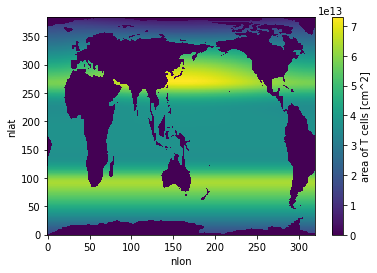

In [6]:
grid = pop_tools.get_grid('POP_gx1v7')
masked_area = grid.TAREA.where(grid.REGION_MASK > 0).fillna(0.)
masked_area.plot()

In [7]:
nmolcm2s_to_molm2yr = 1e-9 * 1e4 * 86400 * 365.
nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 86400 * 365.
nmols_to_TmolSiyr = 1e-9 * 1e-12  * 86400 * 365.

time_slice = slice("1990-01-15", "2015-01-15")
varlist = [
    'photoC_TOT_zint_100m', 
    'Jint_100m_DIC',
    'POC_FLUX_100m', 
    'POP_FLUX_100m', 
    'SiO2_FLUX_100m',
    'CaCO3_FLUX_100m',    
]
ds_list = []
for variable in varlist:
    xp_func = xp.persist_ds(cu.read_CESM_var, name=f'{variable}', trust_cache=True)    
    ds_list.append(xp_func(
        time_slice, 
        variable, 
        mean_dims=['member_id', 'time'], 
    ))

ds = xr.merge(ds_list)    


r_N2C = 16. / 117.
ds['N2P_FLUX_100m'] = ds.POC_FLUX_100m * r_N2C / ds.POP_FLUX_100m
ds['e_ratio'] = ds.POC_FLUX_100m / ds.photoC_TOT_zint_100m

ds_glb = xr.Dataset()
convert_glb = dict(
    photoC_TOT_zint_100m=dict(scale_factor=nmols_to_PgCyr, units='Pg C yr$^{-1}$'),
    POC_FLUX_100m=dict(scale_factor=nmols_to_PgCyr, units='Pg C yr$^{-1}$'),
    CaCO3_FLUX_100m=dict(scale_factor=nmols_to_PgCyr, units='Pg C yr$^{-1}$'),
    SiO2_FLUX_100m=dict(scale_factor=nmols_to_TmolSiyr, units='Tmol Si yr$^{-1}$'),
)
for v in varlist:
    assert ds[v].attrs['units'] == 'mmol/m^3 cm/s'
    assert ds[v].dims == ('nlat', 'nlon')
    
    if v in convert_glb:
        ds_glb[v] = (masked_area * ds[v]).sum() * convert_glb[v]['scale_factor']
        ds_glb[v].attrs['units'] = convert_glb[v]['units']
    
    ds[v] = ds[v] * nmolcm2s_to_molm2yr
    ds[v].attrs['units'] = 'mol m$^{-2}$ yr$^{-1}$'

    
for v in ['N2P_FLUX_100m', 'e_ratio']:
    ds_glb[v] = (masked_area * ds[v]).sum() / masked_area.sum()
ds_glb['N2P_FLUX_100m'].attrs['units'] = 'mol N:mol P'
ds_glb['e_ratio'].attrs['units'] = ''
ds

assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/photoC_TOT_zint_100m.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/Jint_100m_DIC.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/POC_FLUX_100m.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/POP_FLUX_100m.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/SiO2_FLUX_100m.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/CaCO3_FLUX_100m.nc


<xarray.Dataset>
Dimensions:               (nlat: 384, nlon: 320)
Coordinates:
    TLONG                 (nlat, nlon) float64 320.6 321.7 322.8 ... 319.4 319.8
    TLAT                  (nlat, nlon) float64 -79.22 -79.22 ... 72.19 72.19
    ULONG                 (nlat, nlon) float64 321.1 322.3 323.4 ... 319.6 320.0
    ULAT                  (nlat, nlon) float64 -78.95 -78.95 ... 72.41 72.41
Dimensions without coordinates: nlat, nlon
Data variables:
    photoC_TOT_zint_100m  (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    Jint_100m_DIC         (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    POC_FLUX_100m         (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    POP_FLUX_100m         (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    SiO2_FLUX_100m        (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    CaCO3_FLUX_100m       (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    N2P_FLUX_100m         (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    e_ratio               (nlat, nlon) float32 nan nan nan nan ... nan nan nan

In [8]:
client.close()
cluster.close()
del client
del cluster

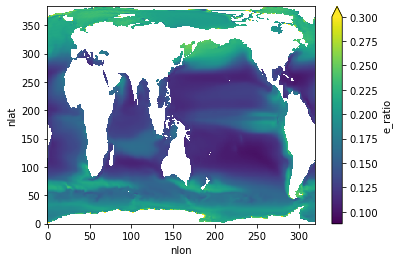

In [9]:
ds.e_ratio.plot(vmax=0.3)

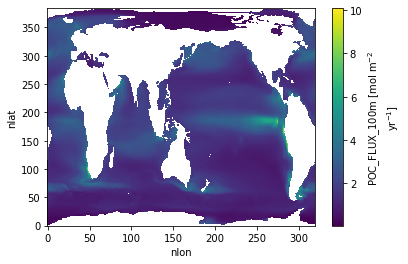

In [10]:
ds.POC_FLUX_100m.plot()

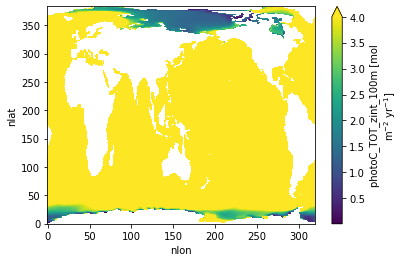

In [11]:
ds.photoC_TOT_zint_100m.plot(vmax=4.)

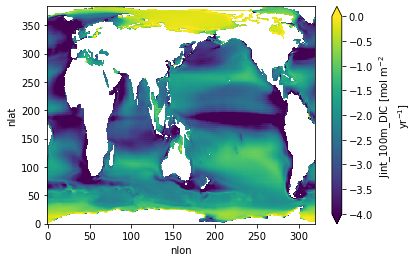

In [12]:
ds.Jint_100m_DIC.plot(vmin=-4., vmax=0.)

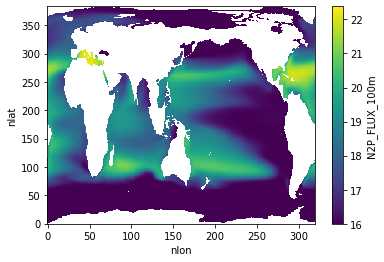

In [13]:
ds.N2P_FLUX_100m.plot()

In [14]:
dsp = utils.pop_add_cyclic(ds)
dsp.info()

xarray.Dataset {
dimensions:
	nlat = 384 ;
	nlon = 321 ;

variables:
	float64 TLAT(nlat, nlon) ;
	float64 TLONG(nlat, nlon) ;
	float32 photoC_TOT_zint_100m(nlat, nlon) ;
		photoC_TOT_zint_100m:units = mol m$^{-2}$ yr$^{-1}$ ;
	float32 Jint_100m_DIC(nlat, nlon) ;
		Jint_100m_DIC:units = mol m$^{-2}$ yr$^{-1}$ ;
	float32 POC_FLUX_100m(nlat, nlon) ;
		POC_FLUX_100m:units = mol m$^{-2}$ yr$^{-1}$ ;
	float32 POP_FLUX_100m(nlat, nlon) ;
		POP_FLUX_100m:units = mol m$^{-2}$ yr$^{-1}$ ;
	float32 SiO2_FLUX_100m(nlat, nlon) ;
		SiO2_FLUX_100m:units = mol m$^{-2}$ yr$^{-1}$ ;
	float32 CaCO3_FLUX_100m(nlat, nlon) ;
		CaCO3_FLUX_100m:units = mol m$^{-2}$ yr$^{-1}$ ;
	float32 N2P_FLUX_100m(nlat, nlon) ;
	float32 e_ratio(nlat, nlon) ;

// global attributes:
}

In [15]:
ds_glb

<xarray.Dataset>
Dimensions:               ()
Data variables:
    photoC_TOT_zint_100m  float64 48.38
    POC_FLUX_100m         float64 7.05
    SiO2_FLUX_100m        float64 78.3
    CaCO3_FLUX_100m       float64 0.7677
    N2P_FLUX_100m         float64 17.09
    e_ratio               float64 0.1478

In [16]:
titles = dict(
    photoC_TOT_zint_100m=f'NPP: {ds_glb["photoC_TOT_zint_100m"].values:0.1f} {ds_glb["photoC_TOT_zint_100m"].units}',
    POC_FLUX_100m=f'POC export (100m): {ds_glb["POC_FLUX_100m"].values:0.1f} {ds_glb["POC_FLUX_100m"].units}',
    e_ratio=f'Export ratio: {ds_glb["e_ratio"].values:0.1f}',
    N2P_FLUX_100m=f'Export N:P ratio: {ds_glb["N2P_FLUX_100m"].values:0.1f} {ds_glb["N2P_FLUX_100m"].units}',
    CaCO3_FLUX_100m=f'CaCO$_3$ export (100m): {ds_glb["CaCO3_FLUX_100m"].values:0.2f} {ds_glb["CaCO3_FLUX_100m"].units}',
    SiO2_FLUX_100m=f'Opal export (100m): {ds_glb["SiO2_FLUX_100m"].values:0.1f} {ds_glb["SiO2_FLUX_100m"].units}',
)
titles

{'photoC_TOT_zint_100m': 'NPP: 48.4 Pg C yr$^{-1}$',
 'POC_FLUX_100m': 'POC export (100m): 7.1 Pg C yr$^{-1}$',
 'e_ratio': 'Export ratio: 0.1',
 'N2P_FLUX_100m': 'Export N:P ratio: 17.1 mol N:mol P',
 'CaCO3_FLUX_100m': 'CaCO$_3$ export (100m): 0.77 Pg C yr$^{-1}$',
 'SiO2_FLUX_100m': 'Opal export (100m): 78.3 Tmol Si yr$^{-1}$'}

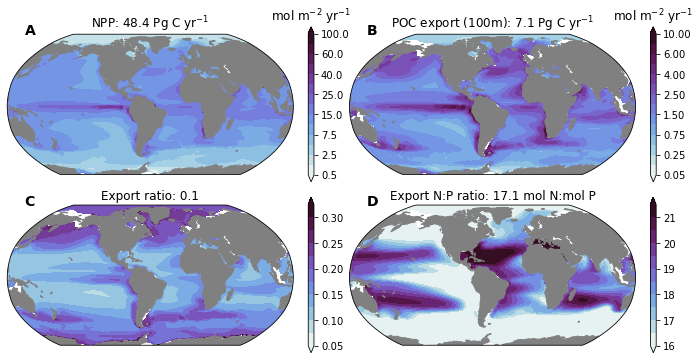

In [17]:
fig = plt.figure(figsize=(12, 6))
prj = ccrs.Robinson(central_longitude=305.0)

nrow, ncol = 2, 2 
gs = gridspec.GridSpec(
    nrows=nrow, ncols=ncol*3, 
    width_ratios=(1, 0.02, 0.02)*ncol,
    wspace=0.15, 
    hspace=0.1,
)

axs = np.empty((nrow, ncol)).astype(object)
caxs= np.empty((nrow, ncol)).astype(object)
for i, j in product(range(nrow), range(ncol)):    
    axs[i, j] = plt.subplot(gs[i, j*3], projection=prj)
    caxs[i, j] = plt.subplot(gs[i, j*3+1])

    
levels = dict(
    photoC_TOT_zint_100m=[0.5, 1., 2.5, 5., 7.5, 10., 15., 20., 25., 30., 40., 50., 60., 80., 100. ],
    POC_FLUX_100m=np.array([0.5, 1., 2.5, 5., 7.5, 10., 15., 20., 25., 30., 40., 50., 60., 80., 100. ])*0.1,
    e_ratio=np.arange(0.05, 0.35, 0.025),
    N2P_FLUX_100m=np.arange(16., 22., 0.5),
)

cmap_field = cmocean.cm.dense

for n, field in enumerate(['photoC_TOT_zint_100m', 'POC_FLUX_100m', 'e_ratio', 'N2P_FLUX_100m']):
    
    i, j = np.unravel_index(n, axs.shape)
    
    ax = axs[i, j]
   
    cf = ax.contourf(
        dsp.TLONG,dsp.TLAT, dsp[field],
        levels=levels[field],
        extend='both',
        cmap=cmap_field,
        norm=colors.BoundaryNorm(levels[field], ncolors=cmap_field.N),
        transform=ccrs.PlateCarree(),
    )

    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature(
            'physical','land','110m',
            edgecolor='face',
            facecolor='gray'
        )
    )  
                             
    ax.set_title(titles[field]) #dsp[field].attrs['title_str'])
    
    cb = plt.colorbar(cf, cax=caxs[i, j])
    if 'units' in dsp[field].attrs:
        cb.ax.set_title(dsp[field].attrs['units'])
    
utils.label_plots(fig, [ax for ax in axs.ravel()], xoff=0.02, yoff=0)       
utils.savefig('bio-pump-NPP-Export-e_ratio-N2P')

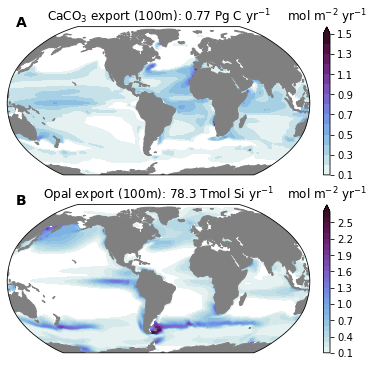

In [18]:
fig = plt.figure(figsize=(6, 6))
prj = ccrs.Robinson(central_longitude=305.0)

nrow, ncol = 2, 1 
gs = gridspec.GridSpec(
    nrows=nrow, ncols=ncol+1, 
    width_ratios=(1, 0.02)*ncol,
    wspace=0.01, 
    hspace=0.2,
)

axs = np.empty((nrow, ncol)).astype(object)
caxs= np.empty((nrow, ncol)).astype(object)
for i, j in product(range(nrow), range(ncol)):    
    axs[i, j] = plt.subplot(gs[i, j], projection=prj)
    caxs[i, j] = plt.subplot(gs[i, j+1])

    
levels = dict(
    CaCO3_FLUX_100m=plot.nice_levels(ds.CaCO3_FLUX_100m),
    SiO2_FLUX_100m=plot.nice_levels(ds.SiO2_FLUX_100m),
)

cmap_field = cmocean.cm.dense

for n, field in enumerate(['CaCO3_FLUX_100m', 'SiO2_FLUX_100m']):
    
    i, j = np.unravel_index(n, axs.shape)
    
    ax = axs[i, j]
   
    cf = ax.contourf(
        dsp.TLONG,dsp.TLAT, dsp[field],
        levels=levels[field],
        extend='max',
        cmap=cmap_field,
        norm=colors.BoundaryNorm(levels[field], ncolors=cmap_field.N),
        transform=ccrs.PlateCarree(),
    )

    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature(
            'physical','land','110m',
            edgecolor='face',
            facecolor='gray'
        )
    )  
                             
    ax.set_title(titles[field]) #dsp[field].attrs['title_str'])
    
    cb = plt.colorbar(cf, cax=caxs[i, j])
    if 'units' in dsp[field].attrs:
        cb.ax.set_title(dsp[field].attrs['units'])
    
utils.label_plots(fig, [ax for ax in axs.ravel()], xoff=0.02, yoff=0)       
utils.savefig('bio-pump-CaCO2-SiO2')